In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, make_axis_great_again, plot_metrics, plot_losses, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '20.05_27.05_rodrigezzzzzzzzzz'

In [4]:
# todo plot iters
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs):
    exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
    batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
    n_epochs = int(n_max_epochs)
    xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch
    
    if title:
        title = 'job #{}: "{}"'.format(job_id, title)
    else:
        title = ''
        
    plot_losses(
        ax, epochs[:n_epochs], xrange,
        # normalize_loss=(0, 1),
        title=title, xlabel='# batch iterations'
    )
    
    plot_metrics(
        ax.twinx(), epochs[:n_epochs], xrange,
        train_metric_ylim=metrics_ylim,
        eval_metric_ylim=metrics_ylim,
        metric_ylabel='average MPJPE relative to pelvis (mm)',
        with_SOTA=True
    )
    
    
    plot_lr(ax, lr_reductions, batch_amount_per_epoch)
    
    make_axis_great_again(ax, xlim=xrange, ylim=[0, 1e2], hide_y=True)

    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2], n_max_epochs=1e3):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row
    
    if len(jobs) > 1:
        for ax, job_id, title in zip(axis.ravel(), jobs, titles):
            plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs)
    else:
        plot_job(axis, jobs[0], titles[0], training_batch_size, metrics_ylim, n_max_epochs)

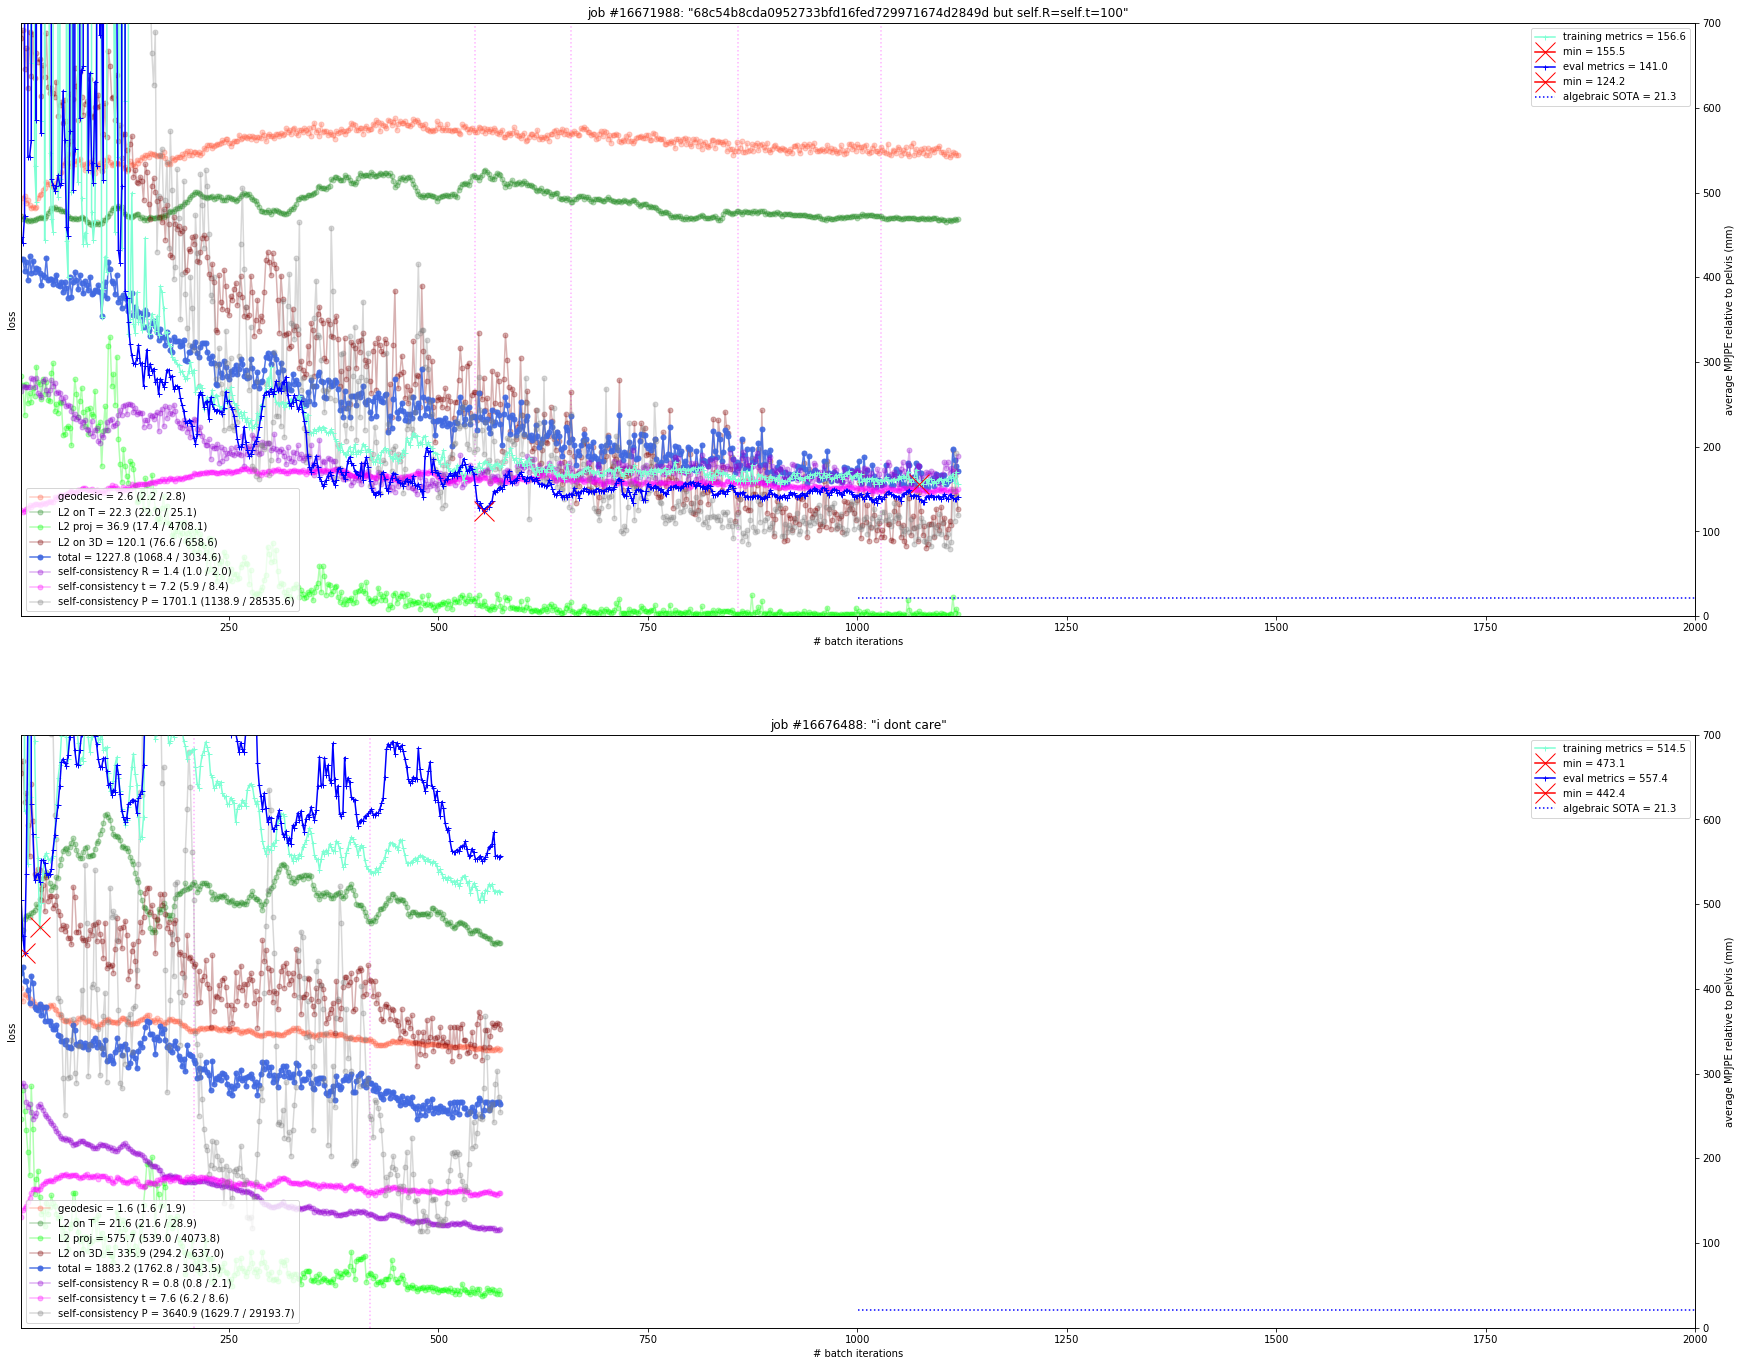

In [254]:
jobs = list(zip(*[
    #('15854643', '6D, arch=shared, loss: geo=10, t=5, 3D=1.0, lr=1e-4'),  # 0c4ebaf24b30a8d33e78a289fbafc2ea4924e169
    #another baseline ('15926479', 'norm Fro, supervision: 3D, R | t'),

    # SOTA superv R|t
    #('16640073', '6f95e67454c63ca59d5b439089493b20632c6372'),
    #('16647158', '=16640073, 10% dataset'),
    
    # SOTA semi-superv R|t
    #('16667398', 'ceff16dbbc887272e10d57242c44579bef033e38'),
     
    # SOTA unsuperv R|t
    #('16671661', '68c54b8cda0952733bfd16fed729971674d2849d but with Rodri'),
    ('16671988', '68c54b8cda0952733bfd16fed729971674d2849d but self.R=self.t=100'),
    #('16673942', 'e04e76d159345ce90d8d6bf6ca7ec9f28bcff28e'),
    ('16676488', 'e04e76d159345ce90d8d6bf6ca7ec9f28bcff28e but 1024 8/4/4, grad_clip=20'),
    #('', 'bd8290718c77a9495e59f48798a979172d5aacd7'),
    
    # todo prova ad aumentare w self.P
    
    #('16559581', '6D self (arch =16366324), loss: 3D=10, self.R=self.t=400, self.P=0.004'),
    #('16581166', '=16559581, loss: 3D=10, self.R=self.t=800, self.P=0.004, lr=2e-4, varying loss ws'),
    #('16568893', '6D self (arch =16366324), loss: 3D=10, self.R=400, self.t=400, self.P=0.004, CLIP GRAD (0.25) + VARY WS'),
    #('16576029', '6D self (arch =16382002), loss: 3D=5, self.R=400, self.t=400, self.P=0.004, CLIP GRAD (0.1, based on current lr) + VARY WS'),
    #('16578071', '6D self (arch =16366324), loss: 3D=10, self.R=400, self.t=400, self.P=0.003, CLIP GRAD (0.1, based on current lr), lr=5e-4'),
    #('16578951', '6D self (arch =16366324), loss: 3D=10, self.R=400, self.t=400, self.P=0.006, CLIP GRAD (0.1, based on current lr), lr=5e-4'),

    # what's the best normalization?
    #('16670579', 'ab0e02487617eece9a3cb3034c304eba9223027e, R is GT, norm=center + Fro'),
    #('16670685', 'ab0e02487617eece9a3cb3034c304eba9223027e, R is GT, norm=Fro'),
    #('16670723', 'ab0e02487617eece9a3cb3034c304eba9223027e, R is GT, norm=mean'),
    
    #('16670984', 'ab0e02487617eece9a3cb3034c304eba9223027e, t is GT, norm=center + Fro'),
    #('16671141', 'ab0e02487617eece9a3cb3034c304eba9223027e, t is GT, norm=mean'),
]))

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 7e2], n_max_epochs=10e2)